In [2]:
from PIL import Image
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
# ## extract data from xml files into txt files
# import xml.etree.ElementTree as ET

# img_width = 504
# img_height = 747

# base_dir = 'data/custom/labels'
# len = 0
# for xml_file in os.listdir(base_dir):
#     if xml_file.endswith('xml'):
#         len += 1
# # print(len)

# for ind in range(len):
#     xml_file = f'{ind}.xml'
#     root = ET.parse(os.path.join(base_dir, xml_file)).getroot()
#     txt_file = f'{ind}.txt'

#     f = open(os.path.join(base_dir, txt_file), 'w+')
#     for object in root.findall('./object/bndbox'):
#         xmin = int(object[0].text)
#         ymin = int(object[1].text)
#         xmax = int(object[2].text)
#         ymax = int(object[3].text)
        
#         xcenter = ((xmin + xmax) / 2.0) / img_width
#         ycenter = ((ymin + ymax) / 2.0) / img_height
#         bbox_width = (xmax - xmin) / img_width
#         bbox_height = (ymax - ymin) / img_height

#         f.write(f'0 {xcenter} {ycenter} {bbox_width} {bbox_height}\n')
#         # print(f'0 {xcenter} {ycenter} {bbox_width} {bbox_height}')
#     f.close()
#     # print('\n')


(504, 747)
(251, 369)


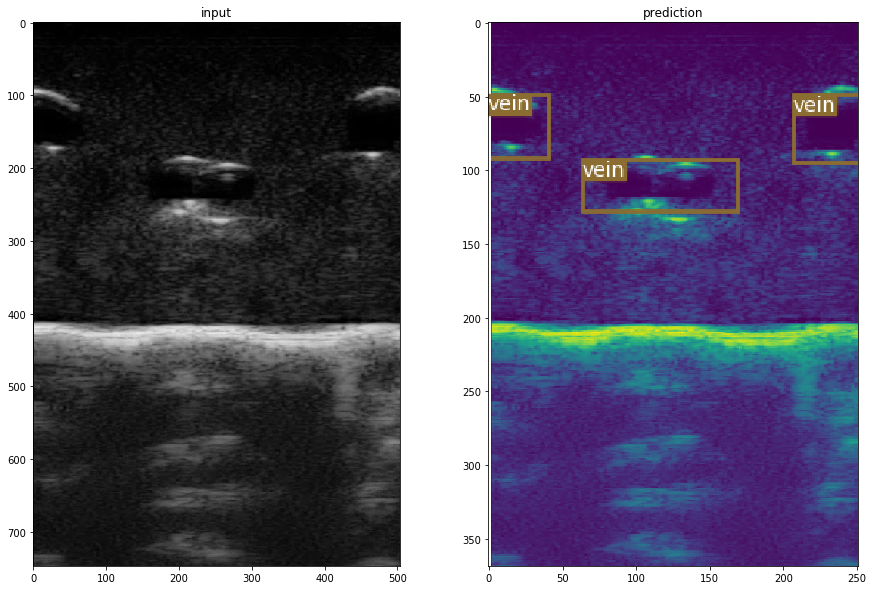

In [6]:
input_img = Image.open('data/custom/images/0.jpg').convert('RGB')
print(input_img.size)

output_img = Image.open('output/0.png')
print(output_img.size)

imgs = [input_img, output_img]
titles = ['input', 'prediction']

itles = [f'input_img: {input_img.size}', f'output_img: {output_img.size}']
plt.figure(figsize=(15,10))
for i, (img, title) in enumerate(zip(imgs, titles)):
    plt.subplot(1, 2, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)